# Workshop 3: Phylogenetic Trees

Welcome! In this workshop, we will go through the typical workflow of how we can construct a tree using biopython packages. There are some exercises at the end of this notebook for you to try yourself. You may need to locate the data by doing your own BLAST search, or you may also download the data folder containing all the files necessary (as this step can be quite tedious and time consuming).  

As a basic demonstration of the overall workflow for making phylogenetic trees, our goal will be to build the tree for the *Coronaviridae* family. 

## Preparing the Data

NCBI has a specific database for coronavirus genomes (https://www.ncbi.nlm.nih.gov/datasets/coronavirus/genomes/). If we select the options (Source database: RefSeq only, Completeness: Complete only, Host: All), we will end up with 66 genomes which we can download directly. However, performing multiple sequence alignment on the complete genome for all 66 sequences is going to take **too long**. Hence, we will only look at the part of the genome that codes for the *spike protein* (https://www.ncbi.nlm.nih.gov/protein/YP_009724390.1). The accession number is **YP_009724390.1**. 

Since we want to look at quite distantly related sequences, we will choose to filter our BLASTP search to only RefSeq proteins. Leaving every search parameter at default settings, we get 68 hits for the spike protein that is associated with a variety of species as hosts. Note: the e-values are all very small indicating that these sequences are indeed homologs.

The 'Download' option let's us download directly all the sequences into one FASTA file format. However, we actually want to align the CDS (complementary DNA sequence) for these proteins. We could do this manually by clicking each entry then going to CDS->FASTA and then checking that the sequence is in the correct form. However, this would take ages and surely, we can do better.

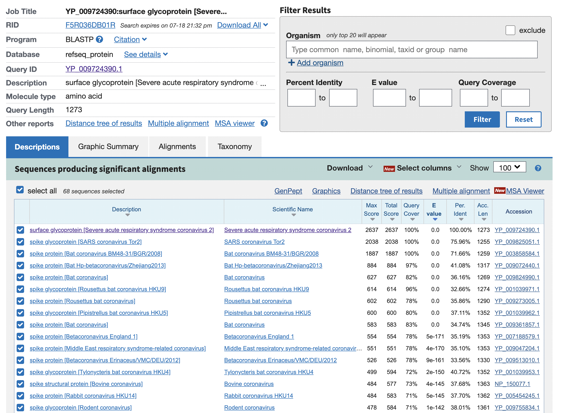

With our newly learnt python scripting knowledge, let's try automate this process so we don't have to make 500+ clicks whilst waiting for NCBI website to load each time. 

The useful information we need is the description, name and accession number for the 68 sequences. We can download this into a csv file by selecting the option 'Download->Descriptions Table (CSV)'.

First, let's check where we are, so we can make sure our relative path for our data is correctly specified. We will use pandas csv reader functionality to load in the csv file. The .head() method enables us to see just the first few lines of the data so we don't get overwhelmed.

In [38]:
import os 
import pandas as pd

print(os.getcwd())
descriptions = pd.read_csv('data/blastp_descriptions.csv')
descriptions.head()

/Users/pikachu/MBSI


,Description,Scientific Name,Max Score,Total Score,Query Cover,E value,Per. ident,Acc. Len,Accession
0,surface glycoprotein [Severe acute respiratory...,Severe acute respiratory syndrome coronavirus 2,2637.0,2637.0,100%,0.0,100.00,1273,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
1,spike glycoprotein [SARS coronavirus Tor2],SARS coronavirus Tor2,2038.0,2038.0,100%,0.0,75.96,1255,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
2,spike protein [Bat coronavirus BM48-31/BGR/2008],Bat coronavirus BM48-31/BGR/2008,1887.0,1887.0,100%,0.0,71.66,1259,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
3,spike protein [Bat Hp-betacoronavirus/Zhejiang...,Bat Hp-betacoronavirus/Zhejiang2013,884.0,884.0,97%,0.0,41.08,1317,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
4,spike protein [Bat coronavirus],Bat coronavirus,627.0,627.0,82%,0.0,36.16,1269,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."


We can see that in the accession column is not what we intended. The data has actually been stored as as a hyperlink that takes us to the page on NCBI with the respective accession number for the protein. No problem, based on observation, we can use simple string splicing to isolate the part we need. Note: if the format was not as standard across all the entries, we would have to rely on more complex pattern extraction techniques such as using regex. 

In [39]:
accession_numbers = []
for link in descriptions.iloc[:,-1]:
    # get the accession numbers and store them
    accession_numbers.append(link.split(',')[-1][1:-2])

descriptions['accession_num'] = accession_numbers
descriptions[['Scientific Name', 'accession_num']]

,Scientific Name,accession_num
0,Severe acute respiratory syndrome coronavirus 2,YP_009724390.1
1,SARS coronavirus Tor2,YP_009825051.1
2,Bat coronavirus BM48-31/BGR/2008,YP_003858584.1
3,Bat Hp-betacoronavirus/Zhejiang2013,YP_009072440.1
4,Bat coronavirus,YP_009824990.1
...,...,...
63,Beluga whale coronavirus SW1,YP_001876437.1
64,Bat coronavirus CDPHE15/USA/2006,YP_008439202.1
65,Porcine epidemic diarrhea virus,NP_598310.1
66,Ferret coronavirus,YP_009256197.1


Our next goal is to retrieve the corresponding CDS sequences and write them to one FASTA formatted file which we will be the input to our multiple sequence alignment. 

In [100]:
from Bio import Entrez, SeqIO
Entrez.email = "Your.Name.Here@example.org"

start_codons = ['ATG']
cds_sequences = []
i = 0
f = open('data/covid_spike_cds_top_20.fasta', 'w+')
for accession_num in descriptions['accession_num'][:21]:
    i+=1
    print(str(i) + ': ' + '_'.join(descriptions['Scientific Name'][i].split(' ')) + '_' + accession_num+'\n')
    f.write('>' + '_'.join(descriptions['Scientific Name'][i].split(' ')) + '_' + accession_num+'\n')
    
    protein_handle = Entrez.efetch(db="protein", id=accession_num, rettype="gb", retmode="text")
    seq_record = SeqIO.read(protein_handle, "genbank")
    for feature in seq_record.features:
        if feature.type == "CDS":
          
            cds_features = feature.qualifiers['coded_by'][0].split(':')
            gene = cds_features[0]
            loc = [int(x) for x in cds_features[1].split('..')]
            
            nuc_handle = Entrez.efetch(db="nucleotide", id=gene, rettype="gb", retmode="text")
            record = SeqIO.read(nuc_handle, "genbank")
            cds_seq = record.seq[loc[0]-1:loc[1]]
            
            if cds_seq[:3] not in start_codons:
                cds_seq = cds_seq.reverse_complement()
            
            cds_sequences.append(cds_seq)
            f.write(str(cds_seq) + '\n')
    

1: SARS_coronavirus_Tor2_YP_009724390.1

2: Bat_coronavirus_BM48-31/BGR/2008_YP_009825051.1

3: Bat_Hp-betacoronavirus/Zhejiang2013_YP_003858584.1

4: Bat_coronavirus_YP_009072440.1

5: Rousettus_bat_coronavirus_HKU9_YP_009824990.1

6: Rousettus_bat_coronavirus_YP_001039971.1

7: Pipistrellus_bat_coronavirus_HKU5_YP_009273005.1

8: Bat_coronavirus_YP_001039962.1

9: Betacoronavirus_England_1_YP_009361857.1

10: Middle_East_respiratory_syndrome-related_coronavirus_YP_007188579.1

11: Betacoronavirus_Erinaceus/VMC/DEU/2012_YP_009047204.1

12: Tylonycteris_bat_coronavirus_HKU4_YP_009513010.1

13: Bovine_coronavirus_YP_001039953.1

14: Rabbit_coronavirus_HKU14_NP_150077.1

15: Rodent_coronavirus_YP_005454245.1

16: Human_coronavirus_OC43_YP_009755834.1

17: Murine_hepatitis_virus_YP_009555241.1

18: Murine_hepatitis_virus_YP_009824982.1

19: Murine_hepatitis_virus_strain_JHM_NP_045300.1

20: Betacoronavirus_HKU24_YP_209233.1

21: Human_coronavirus_HKU1_YP_009113025.1



Great, now that we have our fasta file with all our sequences, we are ready to move onto Multiple Sequence Alignment. Note that we have used only the top 20 sequences from the 68 that we found. This was just done to speed things up a bit. The naming convention of the sequences also ensures that when performing MSA, the species names remain unique. 

## Performing Multiple Sequence Alignment (MSA)

Here, we show how we can use the biopython commandline wrapper and python subprocess module to run a multiple sequence alignment from within python. Alternatively, you may use other programs like https://www.ebi.ac.uk/Tools/msa/muscle/ or the alignment algorithms available within MEGA X. The code below is equivalent to running the command from the terminal. 

In [102]:
import subprocess, sys
from Bio.Align.Applications import ClustalOmegaCommandline

cline = ClustalOmegaCommandline("clustalo", 
                                infile='data/covid_spike_cds_top_20.fasta')

print(cline)

child = subprocess.Popen(str(cline), stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True, shell=(sys.platform!='win32'))

clustalo -i data/covid_spike_cds_top_20.fasta


We can use the AlignIO module to parse in the aligned file which is piped from 'stdout'. This is the output that shows on the terminal if you were to run it from the command line. 

In [103]:
from Bio import AlignIO 

align = AlignIO.read(child.stdout, 'fasta')
print(align)

Alignment with 21 rows and 4444 columns
------------------------------ATGTTT--------...--- SARS_coronavirus_Tor2_YP_009724390.1
---------------------------------ATGT---TTAT...--- Bat_coronavirus_BM48-31/BGR/2008_YP_009825051.1
------------------------------ATGAAAT---TTTT...--- Bat_Hp-betacoronavirus/Zhejiang2013_YP_003858584.1
ATGGTCGCAC---GCTATAGACTCTGCATCTTGCAAC---TTAT...--- Bat_coronavirus_YP_009072440.1
ATGGT---CG---T---CTTATTGTTCGTGATGT------TTAG...TGA Rousettus_bat_coronavirus_HKU9_YP_009824990.1
ATGCTGTTGA---T---ATTGGTGTTAGGGGTGTCGC---TTGC...TGA Rousettus_bat_coronavirus_YP_001039971.1
ATGTTTCGGA---C---GTTGCTCTTAGCGGCGTTGT---TTAA...TGA Pipistrellus_bat_coronavirus_HKU5_YP_009273005.1
ATGAT---AC---GCTCAGTGTTAGTACTGATGTGCTCGTTAAC...--- Bat_coronavirus_YP_001039962.1
ATGAC---GT---ACTCAGTGTCTCTACTGATGTGCTTGTTAAC...--- Betacoronavirus_England_1_YP_009361857.1
ATGAT---AC---ACTCAGTGTTTCTACTGATGTTCTTGTTAAC...--- Middle_East_respiratory_syndrome-related_coronavirus_YP_007188579.1
ATGAT--

As seen above, the alignment isn't perfect. The start codons actually align for the most recently evolved sequences. We could try different alignment algorithms and play around with their parameters. In general, it takes some domain expertise to decide whether an alignment is good. However, our results shouldn't affect the overall topology of the tree which is our primary interest for now. 

## Building the Tree

In the examples below, a distance-based tree is constructed. As explained at the start of this workshop, a distance-based tree relies on the distance matrix. There are many notions of *pairwise distance*. These treat each match and mismatch differently. For example, for coding sequences, it is much more likely that the 3rd position of the codon will mutate. Yet, the codon will still code for the same protein. Hence, a mismatch at the end of codons should be less "penalised" in terms of the alignment score/distance. 

For demonstrative purposes, we will take the most naive way of pairwise scoring (*identity*). This is to simply take the ratio between the number of mismatches and the total length of the sequence. 

In [104]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator 

calculator = DistanceCalculator('identity')
distance_matrix = calculator.get_distance(align)
print(distance_matrix)

SARS_coronavirus_Tor2_YP_009724390.1	0
Bat_coronavirus_BM48-31/BGR/2008_YP_009825051.1	0.24437443744374432	0
Bat_Hp-betacoronavirus/Zhejiang2013_YP_003858584.1	0.27677767776777673	0.2592259225922592	0
Bat_coronavirus_YP_009072440.1	0.48604860486048607	0.48289828982898286	0.49504950495049505	0
Rousettus_bat_coronavirus_HKU9_YP_009824990.1	0.5551305130513051	0.5551305130513051	0.5425292529252925	0.5704320432043204	0
Rousettus_bat_coronavirus_YP_001039971.1	0.5551305130513051	0.5616561656165617	0.5513051305130513	0.5677317731773177	0.3908640864086409	0
Pipistrellus_bat_coronavirus_HKU5_YP_009273005.1	0.5654815481548154	0.5686318631863186	0.5544554455445545	0.5659315931593158	0.4225922592259226	0.37421242124212417	0
Bat_coronavirus_YP_001039962.1	0.578082808280828	0.5753825382538253	0.5837083708370837	0.5875337533753375	0.5960846084608461	0.5976597659765976	0.5987848784878488	0
Betacoronavirus_England_1_YP_009361857.1	0.578082808280828	0.5747074707470747	0.5798829882988299	0.57335733573357

We can now finally make the tree. The default type of distance-based tree built using the .build_tree method employs the Neighbor Joining algorithm. 

In [139]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

constructor = DistanceTreeConstructor(calculator)
covid_tree = constructor.build_tree(align)

# This is equivalent to constructor.nj(distance_matrix)
# Alternatively, to draw a upgma tree, we can do:
# covid_tree = constructor.upgma(distance_matrix)
covid_tree.rooted = True
print(covid_tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner19')
        Clade(branch_length=0.09467052662297479, name='Inner15')
            Clade(branch_length=0.15126983889795237, name='Inner8')
                Clade(branch_length=0.11408992461746167, name='Inner3')
                    Clade(branch_length=0.06766559008842066, name='Betacoronavirus_HKU24_YP_209233.1')
                    Clade(branch_length=0.06127230370095832, name='Inner2')
                        Clade(branch_length=0.0006250625062506066, name='Murine_hepatitis_virus_strain_JHM_NP_045300.1')
                        Clade(branch_length=0.0005000500050005297, name='Murine_hepatitis_virus_YP_009824982.1')
                Clade(branch_length=0.030708539603960416, name='Inner7')
                    Clade(branch_length=0.14775891651665163, name='Human_coronavirus_HKU1_YP_009113025.1')
                    Clade(branch_length=0.01144450382538259, name='Inner6')
                        Clade(branch_length=0.12645310289957568, 

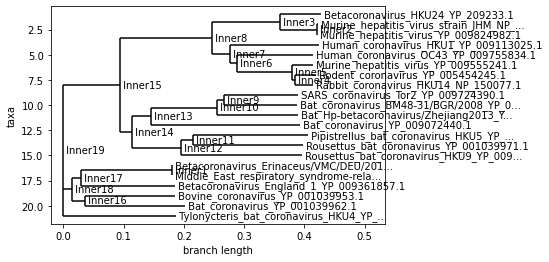

In [107]:
import matplotlib 
import matplotlib.pyplot as plt

fig = Phylo.draw(covid_tree)

Now let's visualise the tree! Unfortunately, we see that the default options don't produce a very appealing result. Let's try fix this. 

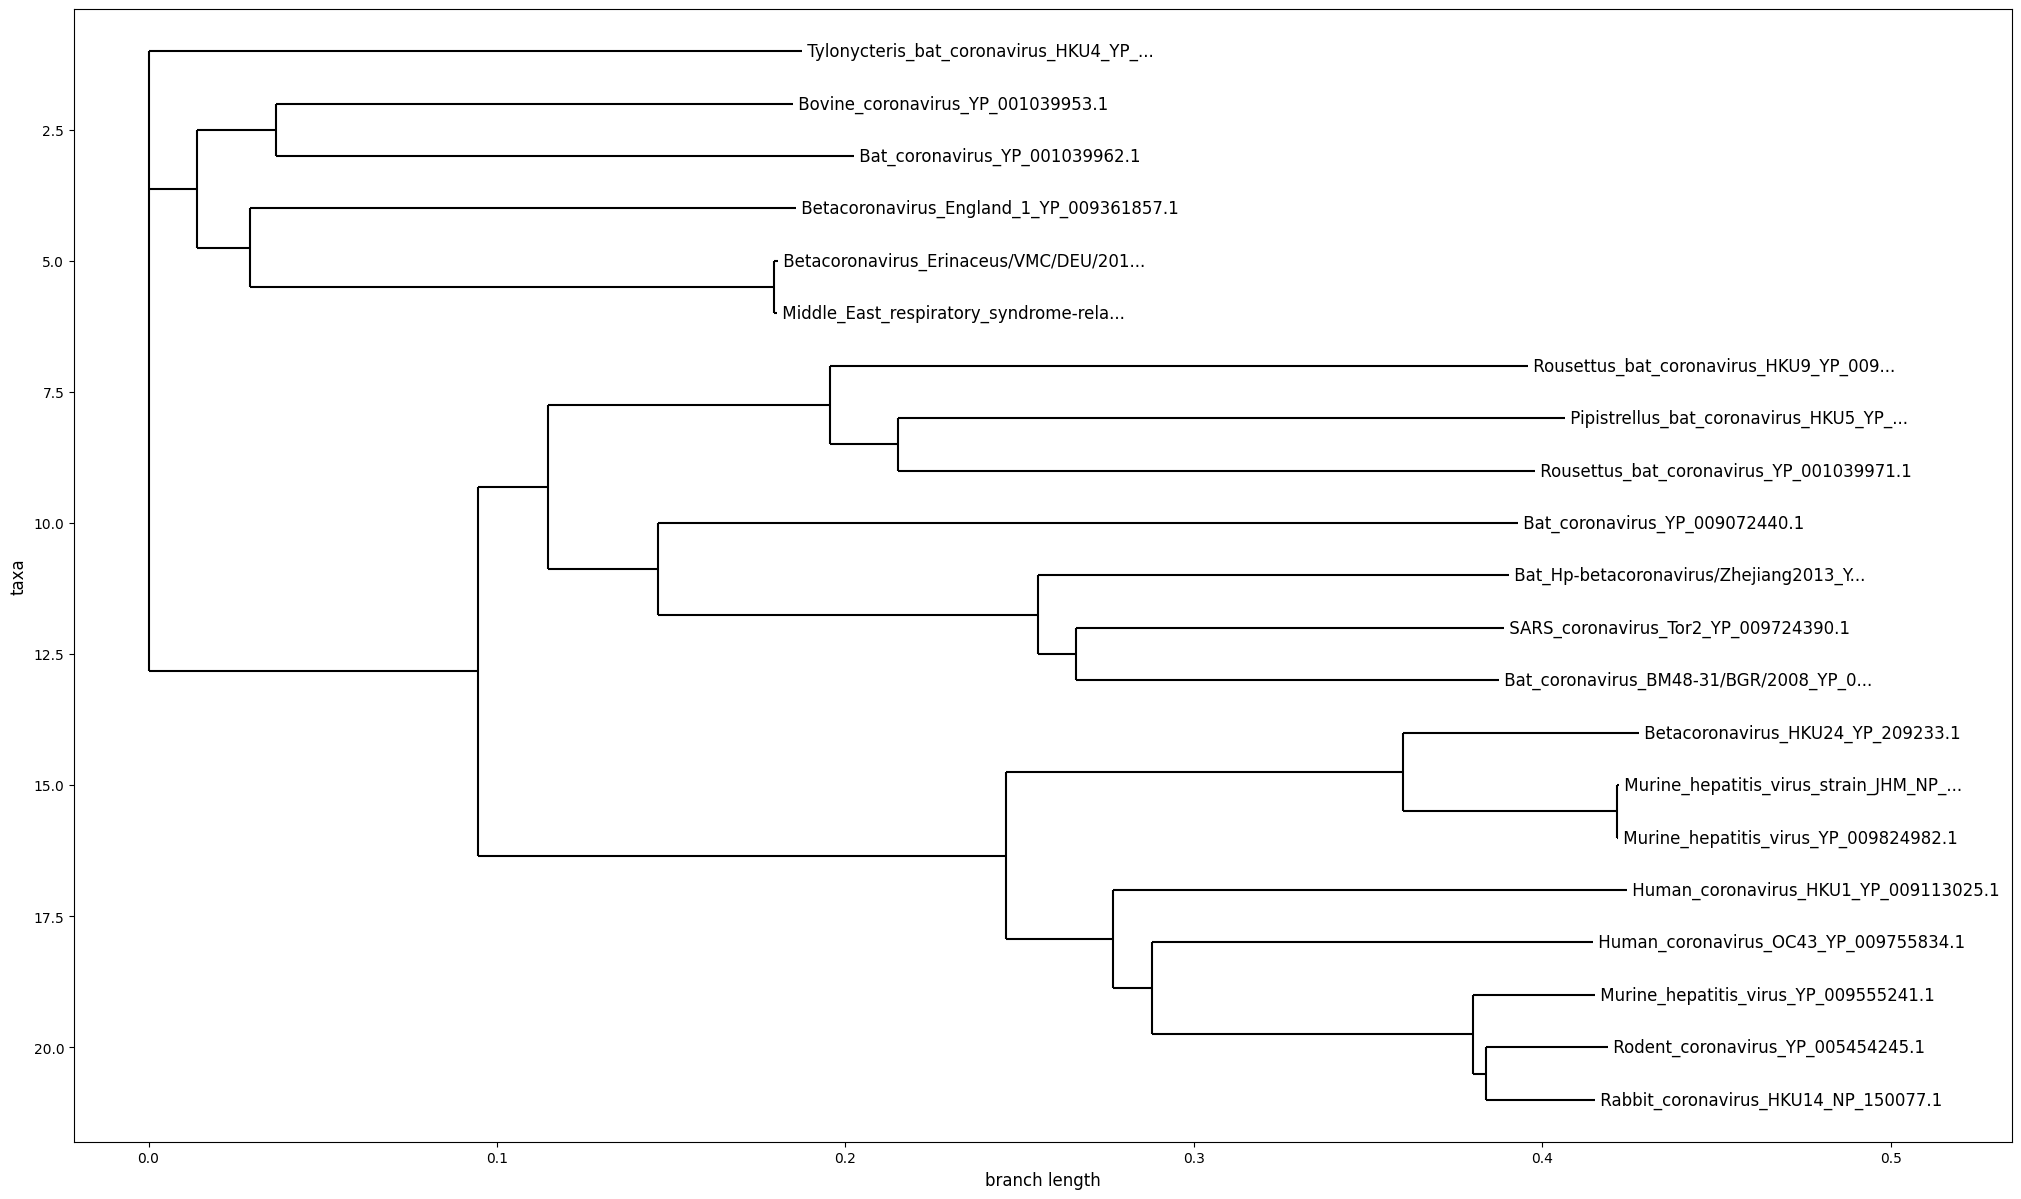

In [144]:
# Remove the clade labels associated with Inner
for clade in covid_tree.find_clades():
    if 'Inner' in clade.name:
        clade.name = ''

# Make a better looking tree using the features of matplotlib 
fig = plt.figure(figsize=(25, 15), dpi=100) # create figure & set the size 
matplotlib.rc('font', size=12)              # fontsize of the leaf and node labels 
matplotlib.rc('xtick', labelsize=10)       # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=10)       # fontsize of the tick labels

# reorganises the clades so the longer branches are at the bottom
covid_tree.ladderize()
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(covid_tree, axes=axes)
fig.savefig("data/covid_cladogram")


The Phylo module also offers the ability to draw an ascii tree. 

In [145]:
Phylo.draw_ascii(covid_tree)

  _____________ Tylonycteris_bat_coronavirus_HKU4_YP_...
 |
 |  ___________ Bovine_coronavirus_YP_001039953.1
 |,|
 |||_____________ Bat_coronavirus_YP_001039962.1
 ||
 || ___________ Betacoronavirus_England_1_YP_009361857.1
 |||
 | |           , Betacoronavirus_Erinaceus/VMC/DEU/201...
 | |___________|
 |             | Middle_East_respiratory_syndrome-rela...
_|
 |               _______________ Rousettus_bat_coronavirus_HKU9_YP_009...
 |         _____|
 |        |     |  ______________ Pipistrellus_bat_coronavirus_HKU5_YP_...
 |        |     |_|
 |       _|       |_____________ Rousettus_bat_coronavirus_YP_001039971.1
 |      | |
 |      | |  ___________________ Bat_coronavirus_YP_009072440.1
 |      | |_|
 |      |   |         __________ Bat_Hp-betacoronavirus/Zhejiang2013_Y...
 |      |   |________|
 |      |            | ________ SARS_coronavirus_Tor2_YP_009724390.1
 |______|            ||
        |             |________ Bat_coronavirus_BM48-31/BGR/2008_YP_0...
        |
        | 

That's it! In reality, there are many more packages to work with trees. We have shown just some of the simplest and easiest methods to use out of the box. If you are interested, other packages to explore include: 

- **Treeswift**: The newest of these packages, Treeswift is designed to handle large tree datasets much more quickly than the others and run statistical analyses on the trees. However, it doesn’t allow the user to create trees, work with sequence data, or directly edit the trees.
- **Dendropy**: This python library also focuses on tree data, allowing users “simulate, process, and manipulate” trees.
- **ETE Toolkit**: ETE provides the best framework for visualizing trees but does not support creating or editing trees.

## Working with MEGA X

### Download & Installation

## Additional Exercises

### Globins

### EbC Gene in Bacteria 

### Single Gene Mutation Causing Disease Case Study: Cystic FIbrosis